# Deconvolution with the deep decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
import torchvision.transforms as T


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
path = './test_data/'
img_name = "poster"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_np).type(dtype)

output_depth = img_np.shape[0]
img_mask_pil = Image.open('./test_data/mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * output_depth)
mask_var = np_to_var(mask_np).type(dtype)

## Generate noisy image

Image size:  (4, 512, 512)


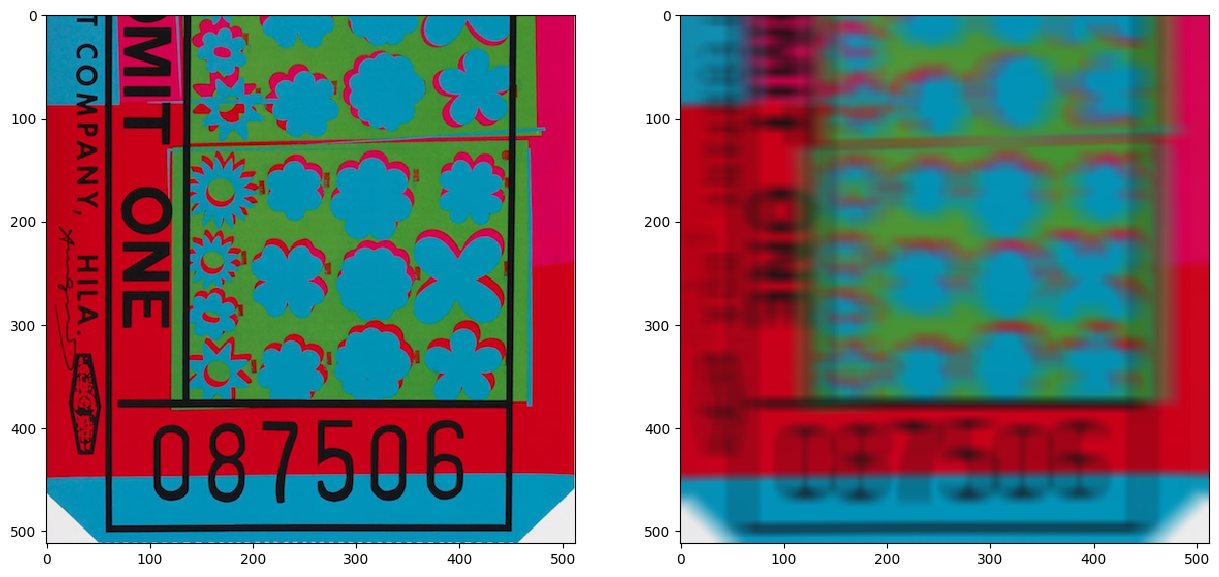

In [4]:
sigma = 255*5
blurrer = T.GaussianBlur(kernel_size=(33, 11), sigma=(sigma, sigma))


def get_noisy_img(sig=255*5,blurrer=blurrer):
    sigma = sig/255.
    img_noisy_pil = blurrer(img_pil)
    img_noisy_np = pil_to_np(img_noisy_pil)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np,img_noisy_var
    
img_noisy_np,img_noisy_var = get_noisy_img(sig=255*700)  
output_depth = img_np.shape[0] 
print("Image size: ", img_np.shape)

fig = plt.figure(figsize = (15,15)) 
ax1 = fig.add_subplot(121)
myimgshow(ax1,img_np)
ax2 = fig.add_subplot(122)
myimgshow(ax2,img_noisy_np)
fig.savefig('deconv_setup.pdf')

In [5]:
def denoise(img_noisy_var,k=128,numit = 1900,rn = 0.0,find_best=True,upsample_first = True,OPTIMIZER='adam',apply_f=None,lr=0.01):
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=upsample_first).type(dtype)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var=img_noisy_var,
                        OPTIMIZER=OPTIMIZER,
                        net=net,
                        img_clean_var=img_clean_var,
                        find_best=find_best,
                        apply_f = blurrer,
                        LR = lr
                        )
    out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    return out_img_np, mse_t, mse_n

shape:  [1, 128, 16, 16]
optimize with adam 0.0025


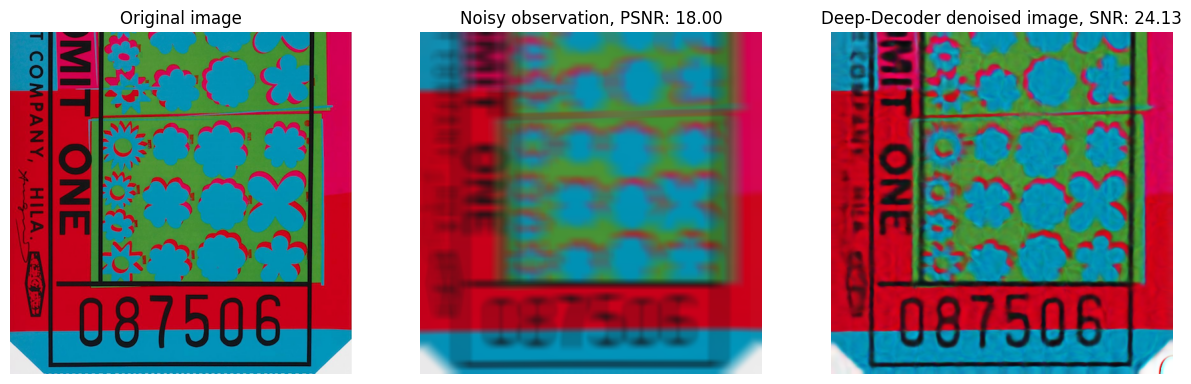

In [6]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))

def plot_results(out_img_np,img_np,img_noisy_np):
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,img_noisy_np)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3,out_img_np)
    ax3.set_title( "Deep-Decoder denoised image, SNR: %.2f" % psnr(img_np,out_img_np) ) 
    ax3.axis('off')    

    plt.show()

sigma = 255*5
blurrer = T.GaussianBlur(kernel_size=(33, 11), sigma=(sigma, sigma))
img_noisy_np,img_noisy_var = get_noisy_img(sig=sigma,blurrer=blurrer)
out_img_np_adam, mse_t_adam, mse_n_adam = denoise(img_noisy_var,k=128,numit = 2500,rn = 0.0,OPTIMIZER='adam',apply_f=blurrer,lr=0.0025)

plot_results(out_img_np_adam,img_np,img_noisy_np)

shape:  [1, 128, 16, 16]
optimize with SophiaG


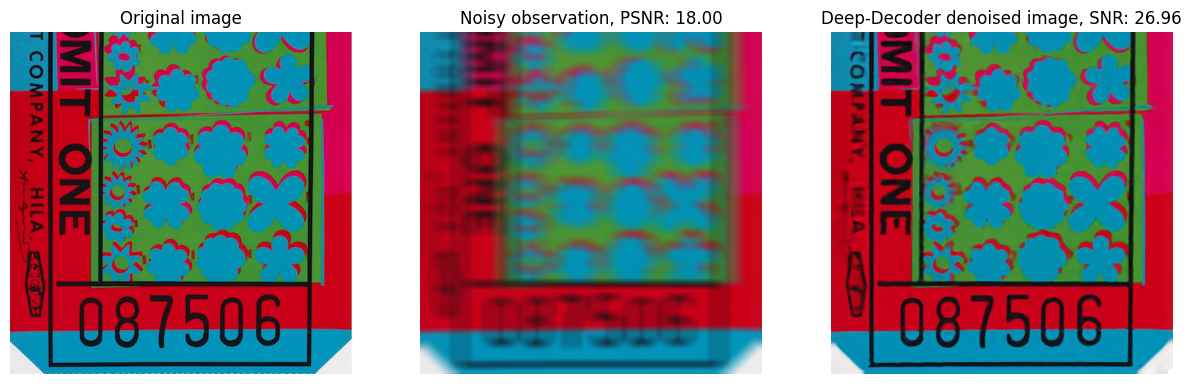

In [7]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))

def plot_results(out_img_np,img_np,img_noisy_np):
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,img_noisy_np)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3,out_img_np)
    ax3.set_title( "Deep-Decoder denoised image, SNR: %.2f" % psnr(img_np,out_img_np) ) 
    ax3.axis('off')    

    plt.show()

sigma = 255*30
blurrer = T.GaussianBlur(kernel_size=(33, 11), sigma=(sigma, sigma))
img_noisy_np,img_noisy_var = get_noisy_img(sig=sigma,blurrer=blurrer)
out_img_np_sophia, mse_t_sophia, mse_n_sophia = denoise(img_noisy_var,k=128,numit = 2500,rn = 0.0,OPTIMIZER='SophiaG',apply_f=blurrer,lr=0.001)

plot_results(out_img_np_sophia,img_np,img_noisy_np)

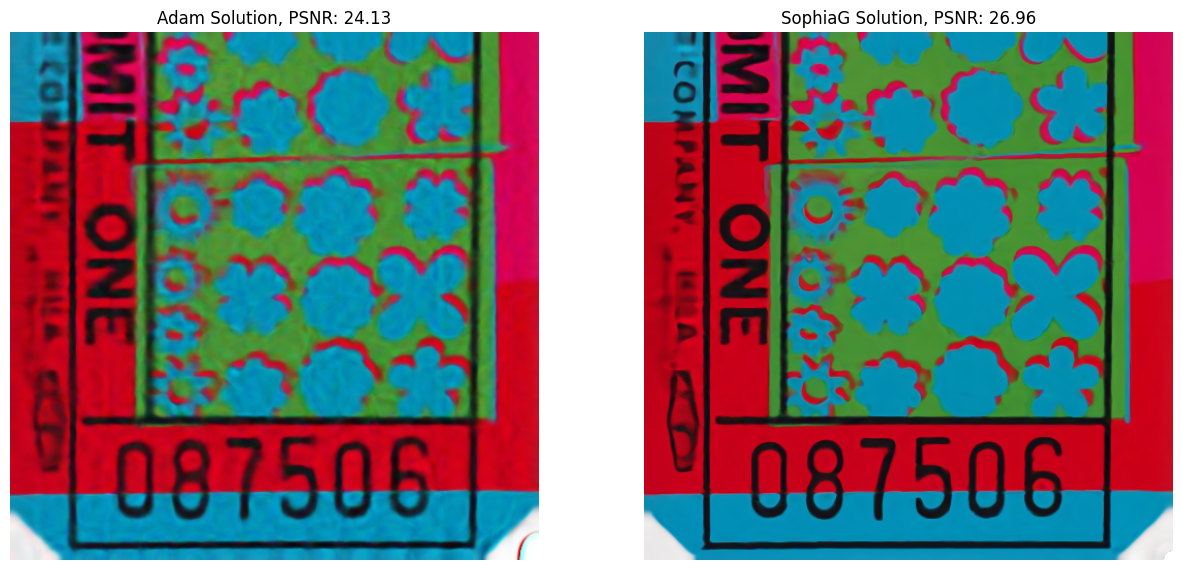

In [8]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
myimgshow(ax1,out_img_np_adam) 
ax1.set_title("Adam Solution, PSNR: %.2f" % psnr(img_np,out_img_np_adam))
ax1.axis('off')
    
ax2 = fig.add_subplot(122)
myimgshow(ax2,out_img_np_sophia)
ax2.set_title( "SophiaG Solution, PSNR: %.2f" % psnr(img_np,out_img_np_sophia) )
ax2.axis('off')
    
fig.savefig('deconv_result.pdf')

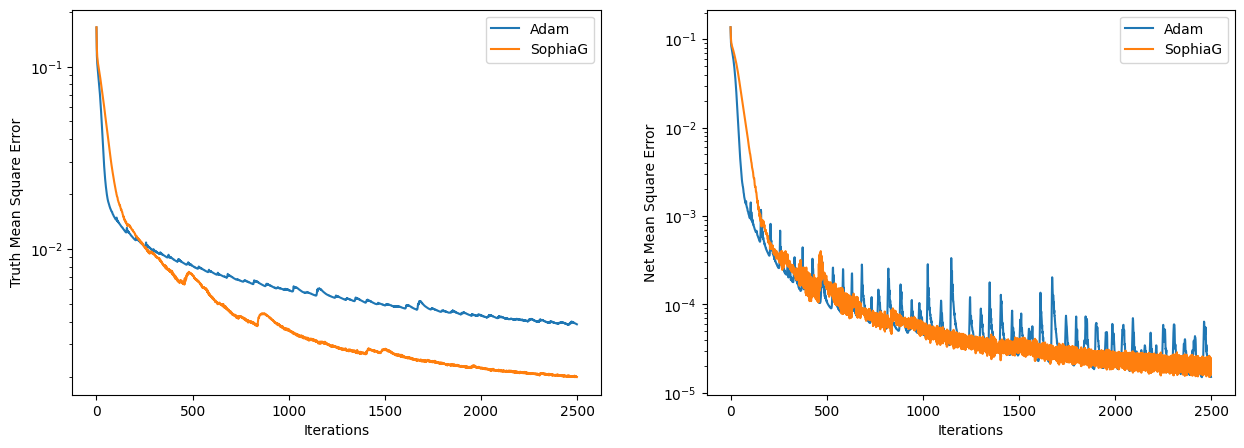

In [9]:
fig = plt.figure(figsize = (15,5)) 
#fig.settitle('Convergence Analysis')

ax1 = fig.add_subplot(121)
#ax1.semilogy(mse_t_sgd,label="SGD")
ax1.semilogy(mse_t_adam,label="Adam")
#ax1.semilogy(mse_t_lbfgs)
ax1.semilogy(mse_t_sophia,label="SophiaG")
#ax1.semilogy(mse_t_sophiah,label="SophiaH")

#ax1.semilogy(mse_t_omd,label="OMD")
ax1.legend(['Adam','SophiaG'])
#ax1.legend(['SGD','Adam','Sophia','OMD'])

ax2 = fig.add_subplot(122)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Truth Mean Square Error')
#ax2.semilogy(mse_n_sgd,label="SGD")
ax2.semilogy(mse_n_adam,label="Adam")
#ax2.semilogy(mse_n_lbfgs)
ax2.semilogy(mse_n_sophia,label="SophiaG")
#ax2.semilogy(mse_n_sophiah,label="SophiaH")

#ax2.semilogy(mse_n_omd,label="OMD")
ax2.legend(['Adam','SophiaG'])
#ax2.legend(['SGD','Adam','Sophia','OMD'])

ax2.set_xlabel('Iterations')
ax2.set_ylabel('Net Mean Square Error')

plt.savefig('deconv_mse.pdf')